In [2]:
import pandas as pd

nov_merged = pd.read_csv('../DATASET/obs_est_merged/nov_merged.csv')

C:\Users\DataScience\AppData\Local\Temp\ipykernel_25748\2877605712.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
nov_merged

,lat,lon,year,month,precip_est,precip_obs,bias_nov
0,45.0,-20.0,1981,12,107.417970,131.149290,-23.731320
1,45.0,-19.0,1981,12,98.339840,126.678470,-28.338630
2,45.0,-18.0,1981,12,92.800780,122.924805,-30.124025
3,45.0,-17.0,1981,12,88.367190,139.038090,-50.670900
4,45.0,-16.0,1981,12,85.582030,123.603820,-38.021790
...,...,...,...,...,...,...,...
230251,20.0,16.0,2017,5,1.878309,0.118256,1.760054
230252,20.0,17.0,2017,5,1.065809,0.591278,0.474531
230253,20.0,18.0,2017,5,1.386122,0.591278,0.794844
230254,20.0,19.0,2017,5,1.241591,1.182556,0.059034


In [4]:
nov_merged = nov_merged.drop(columns=['bias_nov'])

In [5]:
nov_average= nov_merged.groupby(['month', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
nov_average['is_train'] = nov_average['month'].apply(lambda x: x in [12, 1, 2])  # temporary splitting

In [6]:
nov_average

,month,lat,lon,precip_est,precip_obs,is_train
0,1,20.0,-20.0,3.645733,2.457407,True
1,1,20.0,-19.0,2.946839,2.952894,True
2,1,20.0,-18.0,2.271275,2.349642,True
3,1,20.0,-17.0,1.920906,2.645599,True
4,1,20.0,-16.0,1.758146,3.575113,True
...,...,...,...,...,...,...
6391,12,45.0,16.0,103.410651,79.106119,True
6392,12,45.0,17.0,86.551385,67.010138,True
6393,12,45.0,18.0,67.465773,58.495204,True
6394,12,45.0,19.0,59.658373,50.671153,True


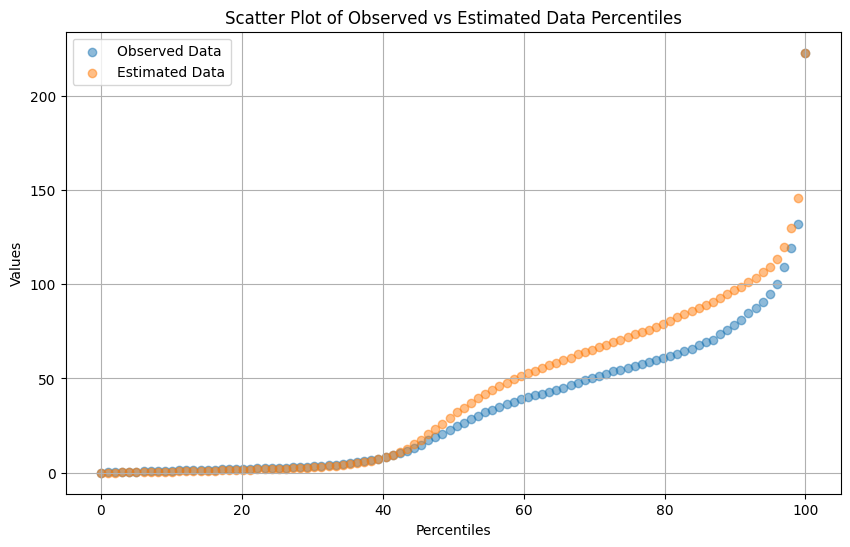

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = nov_average[nov_average['is_train'] == True]['precip_obs']  # ref_data_ast
estimated_data = nov_average[nov_average['is_train'] == True]['precip_est']  # estimated_past

# observed_data = nov_average['precip_obs']  # ref_data_ast
# estimated_data = nov_average['precip_est'] 

# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Estimated Data')

plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an over estimation generally!!

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        percentile = percentileofscore(model_present_safe, model_value)
        percentile_ref = np.percentile(ref_dataset, percentile)
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        model_future_corrected[ival] = model_future_safe[ival] * (1 + dif)
            
    return model_present_corrected, model_future_corrected

In [33]:
# Applying the correction
nov_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = nov_average['is_train']
ref_dataset = nov_average[is_train]['precip_obs']
model_present = nov_average[is_train]['precip_est']
model_future = nov_average[~is_train]['precip_est']

model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future)

# Correct the DataFrame
nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
nov_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

test_data = nov_average[nov_average['is_train'] == False]
nov_average.loc[test_data.index, 'RMSE'] = np.sqrt((test_data['corrected_precip_est'] - test_data['precip_obs'])**2)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_25360\2189392518.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4.09158327  3.47257626  2.86631273 ... 52.00395735 45.0617288
 38.91716637]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nov_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


In [34]:
mean_squared_error = nov_average['RMSE'].mean()

# Step 3: Calculate the Global RMSE
global_rmse = np.sqrt(mean_squared_error)

print("Global RMSE:", global_rmse)

Global RMSE: 2.9630599928859906


In [35]:
nov_average.dtypes

month                     int64
lat                     float64
lon                     float64
precip_est              float64
precip_obs              float64
is_train                   bool
corrected_precip_est    float64
RMSE                    float64
dtype: object

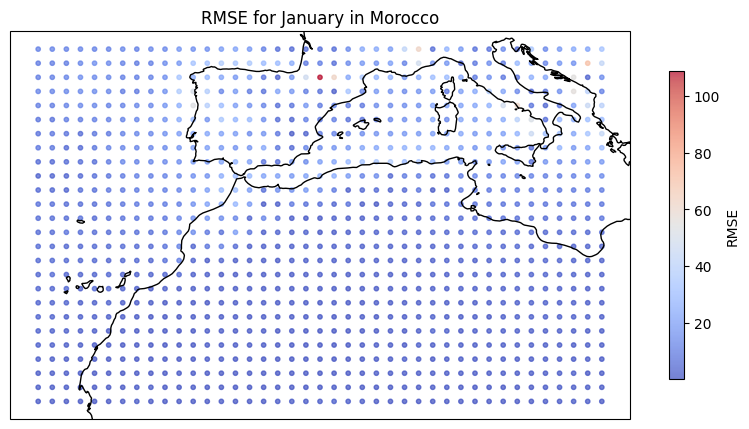

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

# Load your data into a DataFrame.
df = nov_average

# Filter the DataFrame for January and is_train == False.
january_test_df = df[df['month'] == 5]

# Create a scatter plot using plt.scatter for the lat/lon with the color intensity based on the RMSE.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# You might want to adjust the extent to frame Morocco properly
# ax.set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', 
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

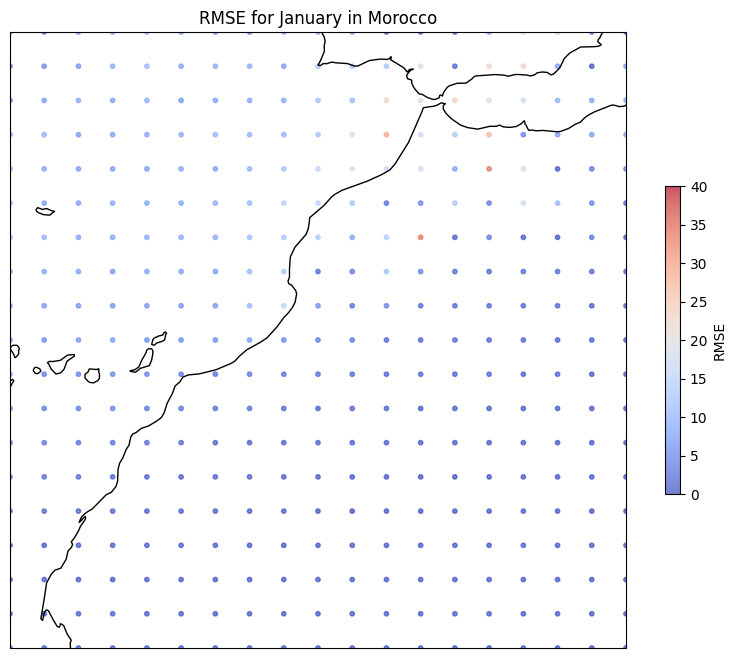

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load your data into a DataFrame.
df = nov_average  # Make sure 'nov_average' is defined and contains your data.

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 4) & (df['is_train'] == False)]

# Start by setting up the figure and axes with the desired size and projection.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to frame Morocco properly.
# This should come before plotting the scatter plot to avoid any overlay issues.
ax.set_extent([-18, 0, 20, 38])

# Add the coastlines to the map for reference.
ax.coastlines()

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', vmin=0, vmax=40,
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

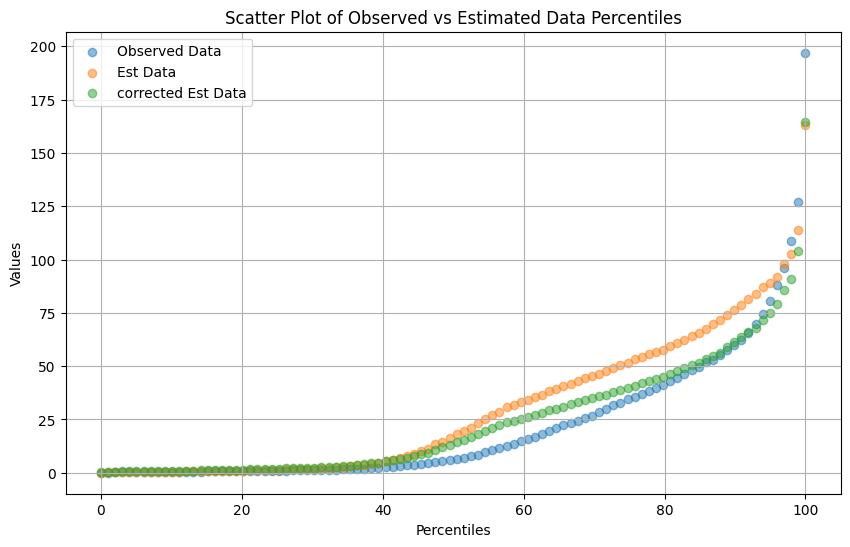

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = nov_average[nov_average['is_train'] == False]['precip_obs']
estimated_data = nov_average[nov_average['is_train'] == False]['precip_est']
corrected_estimated_data = nov_average[nov_average['is_train'] == False]['corrected_precip_est']


# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)
corrected_estimated_percentiles = np.percentile(corrected_estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Est Data')
plt.scatter(percentiles, corrected_estimated_percentiles, alpha=0.5, label='corrected Est Data')


plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an under isitimation generally!!

In [39]:
nov_average

,month,lat,lon,precip_est,precip_obs,is_train,corrected_precip_est,RMSE
0,1,20.0,-20.0,3.645733,2.457407,True,4.091583,NaN
1,1,20.0,-19.0,2.946839,2.952894,True,3.472576,NaN
2,1,20.0,-18.0,2.271275,2.349642,True,2.866313,NaN
3,1,20.0,-17.0,1.920906,2.645599,True,2.481128,NaN
4,1,20.0,-16.0,1.758146,3.575113,True,2.294113,NaN
...,...,...,...,...,...,...,...,...
6391,12,45.0,16.0,103.410651,79.106119,True,87.536992,NaN
6392,12,45.0,17.0,86.551385,67.010138,True,66.503816,NaN
6393,12,45.0,18.0,67.465773,58.495204,True,52.003957,NaN
6394,12,45.0,19.0,59.658373,50.671153,True,45.061729,NaN


In [40]:
nov_rmse = nov_average[nov_average['is_train'] == False].groupby('month')['RMSE'].mean()

nov_rmse.to_csv('../DATASET/for_heatmap/nov_rmse.csv', header=True)

In [41]:
nov_rmse

month
3    9.010786
4    8.598341
5    8.730046
Name: RMSE, dtype: float64

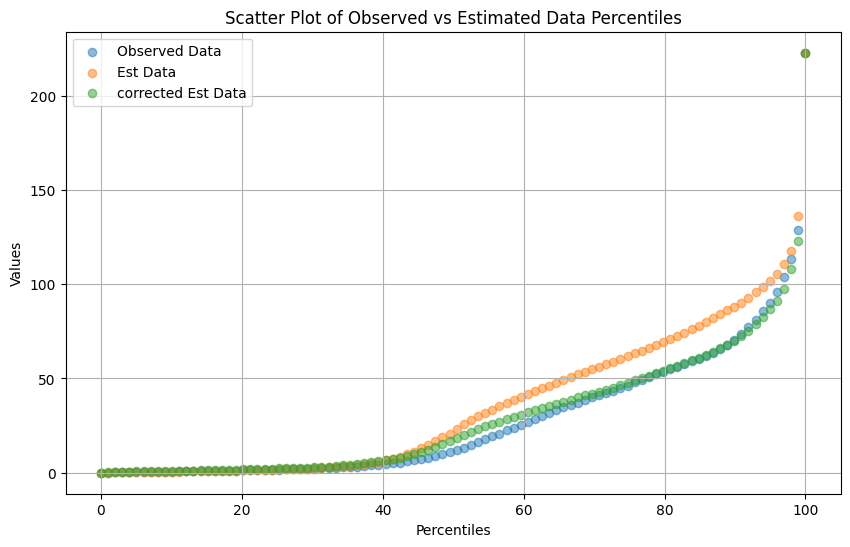

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = nov_average['precip_obs']
estimated_data = nov_average['precip_est']
corrected_estimated_data = nov_average['corrected_precip_est']


# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)
corrected_estimated_percentiles = np.percentile(corrected_estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Est Data')
plt.scatter(percentiles, corrected_estimated_percentiles, alpha=0.5, label='corrected Est Data')


plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
nov_average

,month,lat,lon,precip_est,precip_obs,is_train,corrected_precip_est,RMSE
0,1,20.0,-20.0,3.645733,2.457407,True,4.091583,NaN
1,1,20.0,-19.0,2.946839,2.952894,True,3.472576,NaN
2,1,20.0,-18.0,2.271275,2.349642,True,2.866313,NaN
3,1,20.0,-17.0,1.920906,2.645599,True,2.481128,NaN
4,1,20.0,-16.0,1.758146,3.575113,True,2.294113,NaN
...,...,...,...,...,...,...,...,...
6391,12,45.0,16.0,103.410651,79.106119,True,87.536992,NaN
6392,12,45.0,17.0,86.551385,67.010138,True,66.503816,NaN
6393,12,45.0,18.0,67.465773,58.495204,True,52.003957,NaN
6394,12,45.0,19.0,59.658373,50.671153,True,45.061729,NaN


In [44]:
nov_sub = pd.read_csv ('../DATASET/dataset_test2023/nov23.csv')

nov_sub

,time,lat,lon,prec_est,year,month
0,2023-12-01,40.0,-20.0,2.561035,2023,12
1,2023-12-01,40.0,-19.0,2.514526,2023,12
2,2023-12-01,40.0,-18.0,2.481445,2023,12
3,2023-12-01,40.0,-17.0,2.385254,2023,12
4,2023-12-01,40.0,-16.0,2.340332,2023,12
...,...,...,...,...,...,...
5161,2024-05-01,20.0,16.0,0.007940,2024,5
5162,2024-05-01,20.0,17.0,0.007940,2024,5
5163,2024-05-01,20.0,18.0,0.011663,2024,5
5164,2024-05-01,20.0,19.0,0.011358,2024,5


In [45]:
nov_sub.describe()

,lat,lon,prec_est,year,month
count,5166.000000,5166.000000,5166.000000,5166.000000,5166.000000
mean,30.000000,0.000000,0.707192,2023.833333,4.500000
std,6.055887,11.833305,0.912489,0.372714,3.594324
min,20.000000,-20.000000,0.000000,2023.000000,1.000000
25%,25.000000,-10.000000,0.023926,2024.000000,2.000000
50%,30.000000,0.000000,0.182678,2024.000000,3.500000
75%,35.000000,10.000000,1.273464,2024.000000,5.000000
max,40.000000,20.000000,6.889038,2024.000000,12.000000


In [46]:
nov_average.describe()

,month,lat,lon,precip_est,precip_obs,corrected_precip_est,RMSE
count,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000,3198.000000
mean,4.500000,32.500000,0.000000,34.892709,27.036896,28.428100,8.779725
std,3.594257,7.500586,11.833085,36.838374,32.004694,30.722695,12.166284
min,1.000000,20.000000,-20.000000,0.027187,0.013245,0.019813,0.001903
25%,2.000000,26.000000,-10.000000,1.727828,1.610729,2.234116,0.861614
50%,3.500000,32.500000,0.000000,22.145643,11.567328,17.712876,3.930855
75%,5.000000,39.000000,10.000000,62.120453,46.613746,48.045703,12.258077
max,12.000000,45.000000,20.000000,222.691359,222.577837,222.577837,128.921168


In [47]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        # Calculate the percentile score for the model value
        percentile = percentileofscore(model_present_safe, model_value)
        # Clamp the percentile value to be between 0 and 100
        percentile = max(0, min(100, percentile))
        # Calculate the reference percentile value
        percentile_ref = np.percentile(ref_dataset, percentile)
        # Calculate the difference and adjust model_present
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        # Apply the same adjustment to model_future
        model_future_corrected[ival] = model_future_safe[ival] * (1 + dif)
            
    return model_present_corrected, model_future_corrected

In [48]:
ref_dataset_sub = nov_average[(nov_average['lat'] <= 40)]['precip_obs']
model_present_sub = nov_average[(nov_average['lat'] <= 40)]['precip_est']
model_future_sub = nov_sub['prec_est']

_, model_future_corrected_sub = eQM_porcentual_delta(ref_dataset_sub, model_present_sub, model_future_sub)

# print(len(ref_dataset_sub), len(model_present_sub), len(model_future_sub))

In [49]:
submission_df_nov = pd.DataFrame({ # Example: creating a sequence of IDs from 1 to 781
    'lat': nov_sub['lat'],
    'lon': nov_sub['lon'],
    'month': nov_sub['month'],
    'prec_est': nov_sub['prec_est'],
    'corrected_prec': model_future_corrected_sub,
})

In [50]:
submission_df_nov

,lat,lon,month,prec_est,corrected_prec
0,40.0,-20.0,12,2.561035,2.118323
1,40.0,-19.0,12,2.514526,2.221546
2,40.0,-18.0,12,2.481445,2.293722
3,40.0,-17.0,12,2.385254,2.272276
4,40.0,-16.0,12,2.340332,2.173139
...,...,...,...,...,...
5161,20.0,16.0,5,0.007940,0.007828
5162,20.0,17.0,5,0.007940,0.006459
5163,20.0,18.0,5,0.011663,0.010559
5164,20.0,19.0,5,0.011358,0.009653
